# Rethinking Statistics course in NumPyro - Week 10

Lecture 19: Gaussian Processes

- [Video](https://www.youtube.com/watch?v=pwMRbt2CbSU)
- [Slides](https://speakerdeck.com/rmcelreath/l19-statistical-rethinking-winter-2019)

Lecture 20: Missing Values and Measurement Error

- [Video](https://www.youtube.com/watch?v=UgLF0aLk85s)
- [Slides](https://speakerdeck.com/rmcelreath/l19-statistical-rethinking-winter-2019)

[Proposed problems](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week10.pdf) and [solutions in R](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week10_solutions.pdf) for the exercises of the week.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import jax.numpy as jnp
from jax import ops, random
from jax.scipy.special import expit as logistic
import numpyro
from numpyro.infer import NUTS, MCMC, init_to_value
import numpyro.distributions as dist
from numpyro.distributions.transforms import OrderedTransform

import seaborn as sns
import arviz as az

In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Apr 04 2021

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.21.0

arviz  : 0.11.2
jax    : 0.2.10
seaborn: 0.11.1
scipy  : 1.6.1
numpyro: 0.6.0
numpy  : 1.20.1
pandas : 1.2.3

Watermark: 2.2.0



In [3]:
sns.set_style('whitegrid')
rng_key = random.PRNGKey(0)

## Exercise 1

> Consider the relationship between brain volume (`brain`) and body mass (`body`) in the data(`Primates301`). These values are presented as single values for each species. However, there is always a range of sizes in a species, and some of these measurements are taken from very small samples. So these values are measured with some unknown error.

> We don't have the raw measurements to work with—that would be best. But we can imagine what might happen if we had them. Suppose error is proportional to the measurement. This makes sense, because larger animals have larger variation. As a consequence, the uncertainty is not uniform across the values and this could mean trouble.

> Let's make up some standard errors for these measurements, to see what might happen. Load the data and scale the the measurements so the maximum is 1 in both cases:

In [4]:
d = pd.read_csv('./dat/Primates301.csv', header=0, sep=';')
d.dropna(subset=['brain','body'], inplace=True)
d['B'] = d['brain']/d['brain'].max()
d['M'] = d['body']/d['body'].max()
d['Bse'] = d['B']*0.1
d['Mse'] = d['M']*0.1
d.head()

,name,genus,species,subspecies,spp_id,genus_id,social_learning,research_effort,brain,body,group_size,gestation,weaning,longevity,sex_maturity,maternal_investment,B,M,Bse,Mse
0,Allenopithecus_nigroviridis,Allenopithecus,nigroviridis,NaN,1,1,0.0,6.0,58.02,4655.0,40.0,NaN,106.15,276.0,NaN,NaN,0.118102,0.035808,0.011810,0.003581
2,Alouatta_belzebul,Alouatta,belzebul,NaN,3,3,0.0,15.0,52.84,6395.0,7.4,NaN,NaN,NaN,NaN,NaN,0.107558,0.049192,0.010756,0.004919
3,Alouatta_caraya,Alouatta,caraya,NaN,4,3,0.0,45.0,52.63,5383.0,8.9,185.92,323.16,243.6,1276.72,509.08,0.107130,0.041408,0.010713,0.004141
4,Alouatta_guariba,Alouatta,guariba,NaN,5,3,0.0,37.0,51.70,5175.0,7.4,NaN,NaN,NaN,NaN,NaN,0.105237,0.039808,0.010524,0.003981
5,Alouatta_palliata,Alouatta,palliata,NaN,6,3,3.0,79.0,49.88,6250.0,13.1,185.42,495.60,300.0,1578.42,681.02,0.101533,0.048077,0.010153,0.004808


Now I'll make up some standard errors for B and M, assuming error is 10% of the measurement. Ignoring measurement error, the corresponding `numpyro` model is:

In [5]:
def model(M, B=None):
    # priors
    a = numpyro.sample('a', dist.Normal(0,1))
    b = numpyro.sample('b', dist.Normal(0,0.5))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    # likelihood
    mu = a + b*jnp.log(M)
    numpyro.sample('B_hat', dist.LogNormal(mu, sigma), obs=B)

In [6]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
mcmc.run(rng_key, M=d.M.values, B=d.B.values)

sample: 100%|██████████| 1000/1000 [00:02<00:00, 386.31it/s, 3 steps of size 3.02e-01. acc. prob=0.91]


In [7]:
samples_11 = az.from_numpyro(mcmc)
az.summary(samples_11, var_names=['a','b', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.427,0.059,0.315,0.538,0.002,0.001,884.0,818.0,1.01
b,0.783,0.014,0.755,0.810,0.000,0.000,884.0,635.0,1.01
sigma,0.293,0.015,0.264,0.322,0.000,0.000,1014.0,1033.0,1.00


Your job is to add the measurement errors to this model. Use the divorce/marriage example in the chapter as a guide. It might help to initialize the unobserved true values of `B` and `M` using the observed values. This is done declaring staring values with the help of `init_strategy` parameter.

In [8]:
def model(M, B, Bse, Mse):
    # priors
    a = numpyro.sample('a', dist.Normal(0,1))
    b = numpyro.sample('b', dist.Normal(0,1))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    # likelihood true values
    n = len(M)
    M_true = numpyro.sample('M_true', dist.HalfNormal(0.5,1), sample_shape=(n,))
    mu = a + b*jnp.log(M_true)
    B_true = numpyro.sample('B_true', dist.LogNormal(mu,sigma), sample_shape=(n,))
    # likelihood observed values
    B_obs = numpyro.sample('B_obs', dist.Normal(B_true, Bse), obs=B)
    M_obs = numpyro.sample('M_obs', dist.Normal(M_true, Mse), obs=M)

In [9]:
start = {'M_true':d.M.values, 'B_true':d.B.values}
kernel = NUTS(model, init_strategy=init_to_value(values=start))
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
dat = {k:v.to_numpy() for k,v in d[['M','B','Bse','Mse']].items()}
mcmc.run(rng_key, **dat)

sample: 100%|██████████| 1000/1000 [00:02<00:00, 399.57it/s, 15 steps of size 2.66e-01. acc. prob=0.87] 


In [10]:
samples_12 = az.from_numpyro(mcmc)
az.summary(samples_12, var_names=['a','b', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.421,0.060,0.318,0.539,0.002,0.001,1030.0,1395.0,1.0
b,0.784,0.014,0.758,0.811,0.000,0.000,1053.0,1468.0,1.0
sigma,0.262,0.017,0.230,0.293,0.000,0.000,1917.0,1365.0,1.0


For now, notice that the posterior distributions of a and b are nearly identical to model_11. Adding measurement error hasn't changed a thing! Let's plot the regression against the observed values. The orange points are the posterior mean estimates. Notice that they have moved towards the regression line, as you'd expect. But even the outlier gorillas haven't moved much. The assumed error just isn't big enough to get them any closer. If you increase the amount of error, you can get all of the species to fall right on the regression line. Try for example 30% error. The model will mix poorly, but take a look at the inferred true values. The truth of this example is that there are just so many small primates that they dominate the relationship. And their measurement errors are also smaller (in absolute terms). So adding plausible amounts of measurement error here doesn't make a big difference. We still don't have a good explanation for gorillas.

In [11]:
smp_12 = samples_12.posterior.mean(dim='draw').mean(dim='chain')
d['B_true'] = smp_12.B_true
d['M_true'] = smp_12.M_true

aux = pd.DataFrame()
aux['x'] = np.arange(len(d))/len(d)
aux['avg_curve'] = np.exp(smp_12.a.values)*aux['x']**(smp_12.b.values)

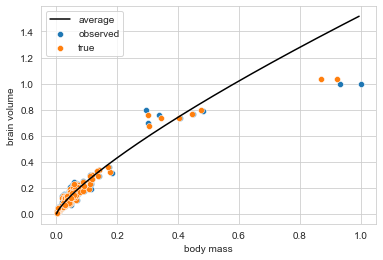

In [12]:
sns.scatterplot(data=d, x='M', y='B')
sns.scatterplot(data=d, x='M_true', y='B_true')
ax = sns.lineplot(data=aux, x='x', y='avg_curve', color='k')
ax.set(xlabel='body mass', ylabel='brain volume')
ax.legend(['average', 'observed', 'true']);

## Exercise 2

> Now consider missing values, this data set is lousy with them. You can ignore measurement error in this problem. Let's get a quick idea of the missing values by counting them in each variable:

In [13]:
d = pd.read_csv('./dat/Primates301.csv', header=0, sep=';')
d.isna().sum()

name                     0
genus                    0
species                  0
subspecies             267
spp_id                   0
genus_id                 0
social_learning         98
research_effort        115
brain                  117
body                    63
group_size             114
gestation              161
weaning                185
longevity              181
sex_maturity           194
maternal_investment    197
dtype: int64

We’ll continue to focus on just brain and body, to stave off insanity. Consider only those species with measured body masses:

In [14]:
d.dropna(subset=['body'], inplace=True)
d['B'] = d.brain/d.brain.max()
d['M'] = d.body/d.body.max()
d.isna().sum()

name                     0
genus                    0
species                  0
subspecies             223
spp_id                   0
genus_id                 0
social_learning         39
research_effort         53
brain                   56
body                     0
group_size              52
gestation               98
weaning                122
longevity              118
sex_maturity           131
maternal_investment    134
B                       56
M                        0
dtype: int64

First, consider whether there is a pattern to the missing values. Does it look like
missing values are associated with particular values of body mass? Draw a DAG that
represents how missingness works in this case. Which type (MCAR, MAR, MNAR)
is this? Compare the inferences to an analysis that drops all the missing values. Has anything changed? Why or why not? Hint: Consider the density of data in the ranges where there are missing values. You might want to plot the imputed brain sizes together with the observed values.

Looks like the missing brain values are almost all for small bodied species. This implies at least a MAR (dog eats students homework) mechanism. Let's try a DAG to express it. `M` here is body mass, `B` (unobserved, suggested by the circle) is brain size, R_B is the missingness mechanism, and `B*` is the observed brain sizes (with missing values). The arrow from `M` to `R_B` indicates that body size influences missingness. In this case, it would imply that small body size makes a missing brain value more likely. 

<img src="./fig/w10_img1.png" width="20%">

Now let's do some imputation. Remember that the model for imputation is really no different than an ordinary model. It just needs a prior for any variable with missing values. In this case, the missing values are in the outcome, so the likelihood is the prior we need. So the model doesn't change at all.

In [15]:
def model(M, B=None):
    # priors
    a = numpyro.sample('a', dist.Normal(0,1))
    b = numpyro.sample('b', dist.Normal(0,1))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    # likelihood
    mu = a + b*jnp.log(M)
    B_naix = np.argwhere(np.isnan(B)).flatten()
    B_impute = numpyro.sample('B_impute', dist.LogNormal(mu[B_naix],sigma))
    B = ops.index_update(B, B_naix, B_impute)
    numpyro.sample('B_hat', dist.LogNormal(mu,sigma), obs=B)

In [16]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
mcmc.run(rng_key, M=d.M.values, B=d.B.values)

sample: 100%|██████████| 1000/1000 [00:01<00:00, 550.72it/s, 15 steps of size 2.10e-01. acc. prob=0.93]


In [17]:
samples_21 = az.from_numpyro(mcmc)
az.summary(samples_21, var_names=['a','b', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.433,0.048,0.346,0.523,0.001,0.001,1380.0,1378.0,1.0
b,0.790,0.012,0.766,0.812,0.000,0.000,1258.0,1342.0,1.0
sigma,0.257,0.012,0.234,0.279,0.000,0.000,1861.0,1360.0,1.0


The same analysis on only complete cases:

In [18]:
d = pd.read_csv('./dat/Primates301.csv', header=0, sep=';')
d.dropna(subset=['body', 'brain'], inplace=True)
d['B'] = d.brain/d.brain.max()
d['M'] = d.body/d.body.max()

In [19]:
def model(M, B=None):
    # priors
    a = numpyro.sample('a', dist.Normal(0,1))
    b = numpyro.sample('b', dist.Normal(0,1))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    # likelihood
    mu = a + b*jnp.log(M)
    numpyro.sample('B_hat', dist.LogNormal(mu,sigma), obs=B)

In [20]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
mcmc.run(rng_key, M=d.M.values, B=d.B.values)

sample: 100%|██████████| 1000/1000 [00:02<00:00, 444.61it/s, 7 steps of size 3.11e-01. acc. prob=0.89]


In [21]:
samples_22 = az.from_numpyro(mcmc)
az.summary(samples_22, var_names=['a','b', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.427,0.057,0.315,0.536,0.002,0.001,880.0,620.0,1.01
b,0.783,0.014,0.758,0.811,0.000,0.000,926.0,942.0,1.00
sigma,0.294,0.016,0.266,0.323,0.000,0.000,1045.0,1026.0,1.00


Really no difference from before. Let's plot the imputed values:

In [22]:
d = pd.read_csv('././dat/Primates301.csv', header=0, sep=';')
d.dropna(subset=['body'], inplace=True)
d['B'] = d['brain']/np.max(d['brain'])
d['M'] = d['body']/np.max(d['body'])

naix = np.isnan(d.B)
di = d[naix][['B','M']].copy()
b_hat = samples_21.posterior.mean(dim='chain').mean(dim='draw').B_impute.values
di.B = b_hat

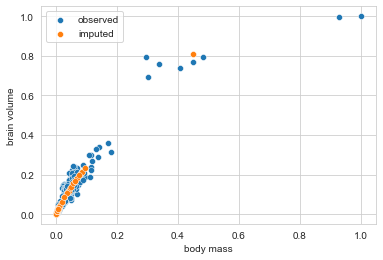

In [23]:
sns.scatterplot(data=d, x='M', y='B')
ax = sns.scatterplot(data=di, x='M', y='B')
ax.set(xlabel='body mass', ylabel='brain volume')
ax.legend(['observed', 'imputed']);

Orange open points are the mean imputed values. Imputation hasn't done much, apparently because all but one of the missing values are in a very dense region of the body size range. So almost no information was lost, the missing info is redundant.